In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import skimage
from scipy.ndimage.measurements import histogram
from skimage.filters.rank import entropy
from sklearn.cluster import KMeans
from scipy import ndimage
import impavi 

# Image Segmentation techniques ( 2/3 )

The second image I will work with has a high structural complexity of the edges. This patterns will cause problems to the state of the art algorithms. This part of the study will provide a new way of obtaining features that can easily differentiate the two regions (cut and tissue). As you can see in the image below, **segmentation can not be performed based on color** so I will have to find other properties that vary between regions. 

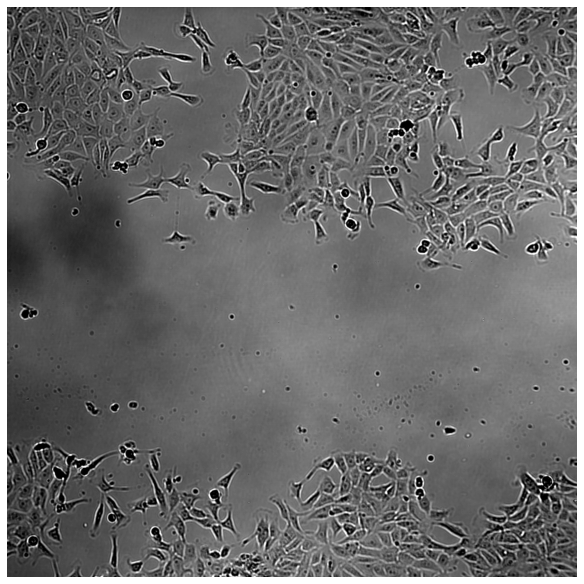

In [2]:
impavi.show('DIC_SN_15_L7_Sum00.tif')

## State of the Art algorithms results

The function below displays the results obtained by the state of the art algorithms whith the corresponding SSIM obtained by each one. Note that it also shows the manually segmented image which will be used as target for the rest of the project.

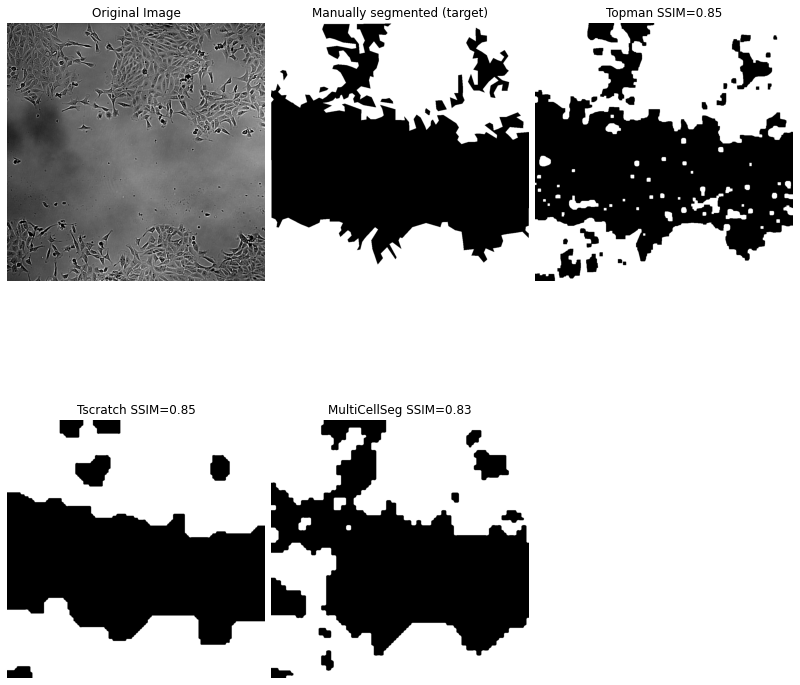

In [3]:
impavi.state_of_the_art('DIC_SN_15_L7_Sum00')

Once again, equalizing the image improves contrast and texture in tissue regions. 

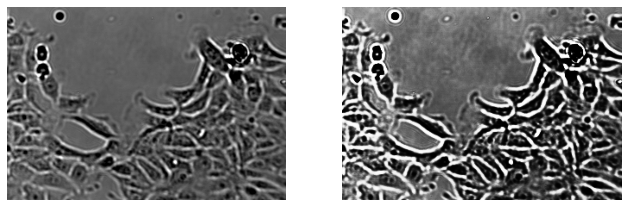

In [5]:
im = plt.imread('DIC_SN_15_L7_Sum00.tif')
im_eq = impavi.equalize(im,plot=False)

plt.figure(figsize=(11,11))
plt.subplot(121)
plt.axis('off')
plt.imshow(im[800:,700:],cmap='gray')
plt.subplot(122)
plt.axis('off')
plt.imshow(im_eq[800:,700:],cmap='gray')

# Edge enhancement approach 
## KIRSCH COMPASS KERNEL

I decided to apply this a technique which will exploit the edges of the tissue (and the absence of edges of the cut). This algorithm published in by *Kirsch, R. (1971)* in "*Computer determination of the constituent structure of biological images*" will give a very useful result to later apply the median filter.

(-0.5, 1023.5, 1023.5, -0.5)

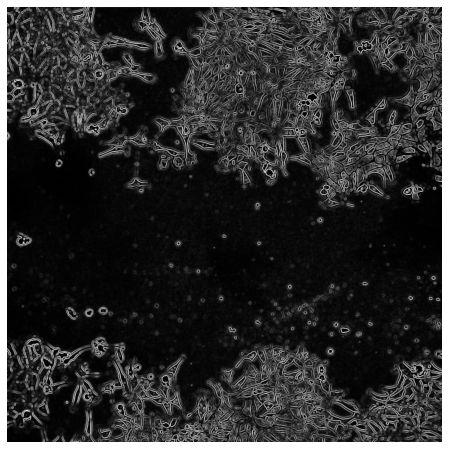

In [6]:
# I built the "impavi" module with fully documented functions with explanations and comments
im_kirsch = impavi.kirsch_compass_kernel(im_eq)
plt.figure(figsize=(8,8))
plt.imshow(im_kirsch,cmap='gray')
plt.axis('off')

With all the esdges enhanced, I proceed to apply median filters of diferent sizes in order to preserve the structure of the edges.

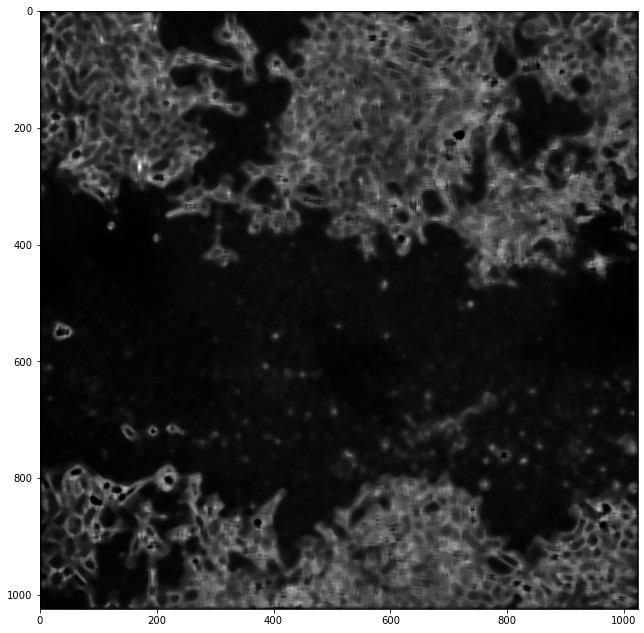

In [9]:
media = scipy.signal.medfilt2d(im_kirsch, kernel_size=11)
plt.figure(figsize=(11,11))
plt.imshow(media,cmap='gray')

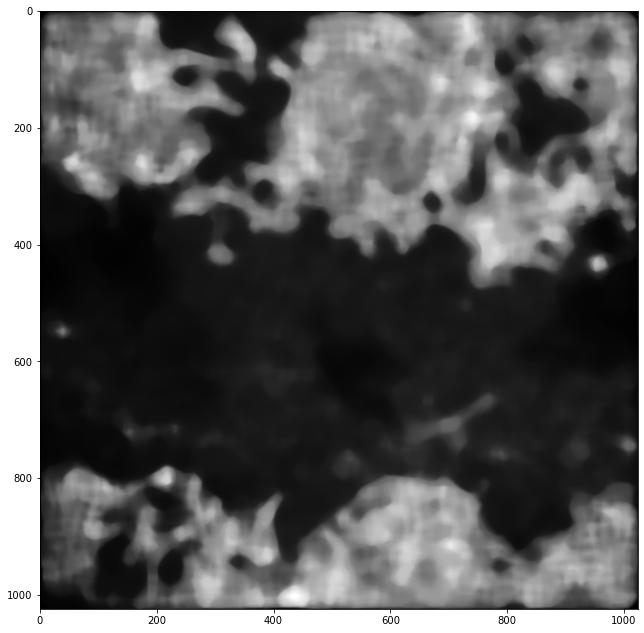

In [10]:
media2 = scipy.signal.medfilt2d(media, kernel_size=[31,31])
plt.figure(figsize=(11,11))
plt.imshow(media2,cmap='gray')

In this case we **must not** apply a low-pass filter. I binarize the image directly, otherwise, I would lose all the detailed I managed to preserve during the median filters application. In this case, the detailes plays a very important role since the cells form complex patterns.

A binarizing threshold of 0.75 times the Otsu's threshold results in an optimal SSIM

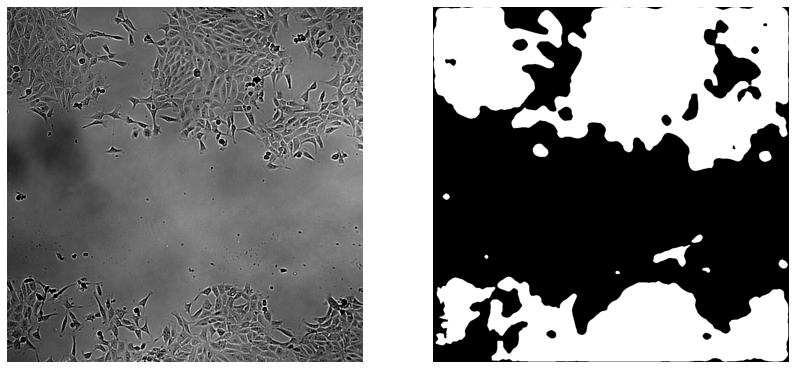

In [12]:
final = media2>skimage.filters.threshold_otsu(media2)*0.75
plt.figure(figsize=(14,14))
plt.subplot(121)
plt.axis('off')
plt.imshow(im,cmap='gray')
plt.subplot(122)
plt.axis('off')
plt.imshow(final,cmap='gray')

## SSIM of my result and of all the other algorithms

I finally proceed to compare the result obtained with the solution built manually provided in the dataset. 

In [14]:
target = plt.imread('DIC_SN_15_L7_Sum00_manual.png')
ssim = skimage.metrics.structural_similarity(target,final)
print('The SSIM between the target and my result is:',ssim)

The SSIM between the target and my result is: 0.8657424291360187


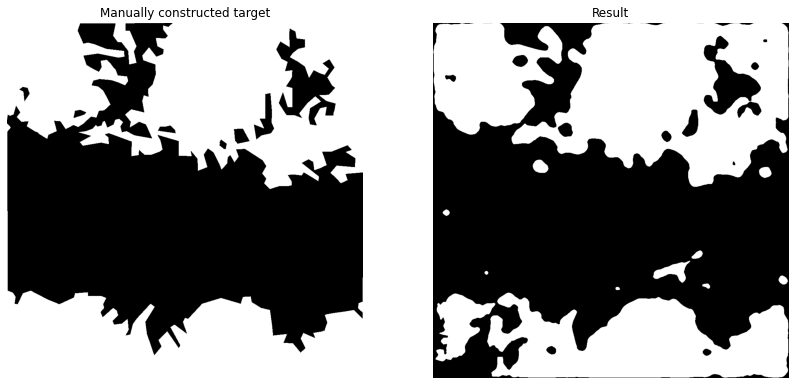

In [15]:
plt.figure(figsize=(14,14))
plt.subplot(121)
plt.axis('off')
plt.title('Manually constructed target')
plt.imshow(target,cmap='gray')
plt.subplot(122)
plt.axis('off')
plt.title('Result')
plt.imshow(final,cmap='gray')

The next function computes SSIM between the target and also of all possible combinations between my result and the state of the art algorithms' results. This provides a correlation matrix that can be represented with highly visual information about the performance of each one of the results.

<AxesSubplot:>

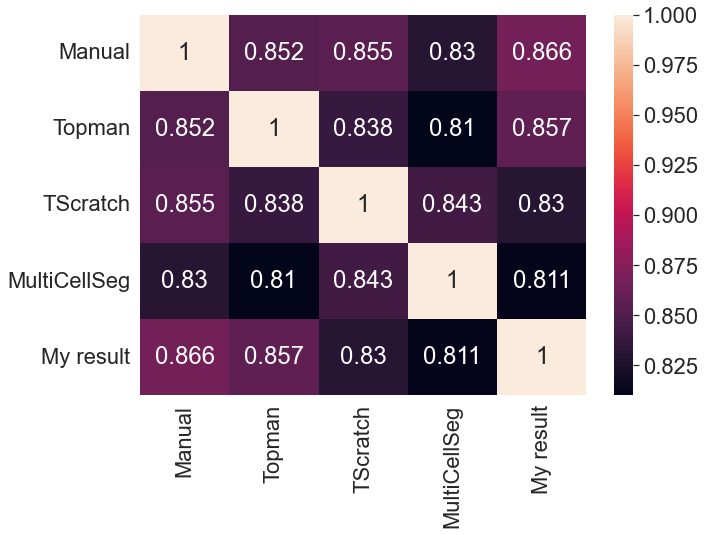

In [13]:
ssim = impavi.ssim_matrix('DIC_SN_15_L7_Sum00',final)

import seaborn as sn
import pandas as pd

sn.set(font_scale=2)

df_cm = pd.DataFrame(ssim, index = [i for i in ['Manual','Topman','TScratch','MultiCellSeg','My result']],
                  columns = [i for i in ['Manual','Topman','TScratch','MultiCellSeg','My result']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='.3g',)
